#Install packages and load libraries

Install non-native packages



Import common packages

In [ ]:
import cProfile, copy, datetime
from google.colab import output
import glob, itertools
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle, pstats
import seaborn as sns
import shutil, sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, average_precision_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

In [ ]:
def readFile(inputName, inputType):

  if inputType=='pairs':
    output = pd.read_csv(inputName,
                         sep=' ',
                         names=['id1', 'id2', 'score'],
                         dtype={'id1': 'str', 'id2': 'str', 'score': 'float'})
    output.insert(2, 'pairsFrozen',
                  output.loc[:, ['id1', 'id2']].apply(frozenset, axis=1))

  elif inputType=='complexes':

    output = []
    input = open(inputName, 'r')
    for line in input.readlines():
        output.append([str(prot) for prot in line.split('\n')[0].split(',')])
    input.close()

  return output

In [ ]:
def scoreCluster(cluster, pairsDF):

  possiblePairs = \
    [frozenset(pair) for pair in list(itertools.combinations(cluster, 2))]
  presentPairsDF = pairsDF.loc[((pairsDF.pairsFrozen.isin(possiblePairs)) & (pairsDF.score > 0)), :].copy()
  minScore = presentPairsDF.score.min()
  meanScore = presentPairsDF.score.mean()

  return [cluster, frozenset(cluster), minScore, meanScore]

unit test

In [ ]:
def estETA(numRuns, timeElapsed, totalRuns):
  print(str((timeElapsed*totalRuns)/(60*numRuns)) + ' minutes estimated')

In [ ]:
shutil.rmtree('./sample_data/')

manual

In [ ]:
clust = elcfsPredictions_complexes['Mean'][0]
print(clust)

posPairs = [frozenset(pair) for pair in list(itertools.combinations(clust, 2))]
print(len(posPairs))
pairsDF = elcfsPredictions_pairs['Mean'].copy()
presentPairs_df = \
  pairsDF.loc[((pairsDF.pairsFrozen.isin(posPairs)) & (pairsDF.score > 0)), :].copy()
min = presentPairs_df.score.min()
avg = presentPairs_df.score.mean()

print(min, avg)

['10236', '10844', '25913', '3178', '3181', '4088', '55558', '7095', '80012', '8140', '9590', '989']
66
0.0010418891906738 0.24915902733270698


programmatic

In [ ]:
scoreCluster(clust, elcfsPredictions_pairs['Mean'])

[['10236',
  '10844',
  '25913',
  '3178',
  '3181',
  '4088',
  '55558',
  '7095',
  '80012',
  '8140',
  '9590',
  '989'],
 frozenset({'10236',
            '10844',
            '25913',
            '3178',
            '3181',
            '4088',
            '55558',
            '7095',
            '80012',
            '8140',
            '9590',
            '989'}),
 0.0010418891906738,
 0.24915902733270698]

In [ ]:
%prun -l itertools.combinations
scoreCluster(clust, elcfsPredictions_pairs['Mean'])

[['10236',
  '10844',
  '25913',
  '3178',
  '3181',
  '4088',
  '55558',
  '7095',
  '80012',
  '8140',
  '9590',
  '989'],
 frozenset({'10236',
            '10844',
            '25913',
            '3178',
            '3181',
            '4088',
            '55558',
            '7095',
            '80012',
            '8140',
            '9590',
            '989'}),
 0.0010418891906738,
 0.24915902733270698]

In [ ]:
def getDifference_stats(cellType_pair, scoredComplexes, refComplexes):

  print(cellType_pair)
  commonComplexes = \
    set.intersection(*[set([ele[1] for ele in scoredComplexes[cellType]])
    for cellType in cellType_pair])

  commonComplexes_indexedBack = pd.concat(
      [
          pd.DataFrame([
              [idx for idx, ref in enumerate(scoredComplexes[cellType]) if ref[1]==cplx]
              for cellType in cellType_pair]).T
      for cplx in commonComplexes], ignore_index=True)
  commonComplexes_indexedBack.rename(
      columns=dict(zip(commonComplexes_indexedBack.columns, cellType_pair)), inplace=True)

  commonComplexes_statsDF = \
    pd.DataFrame(
        {'complex': [','.join(list(cplx)) for cplx in list(commonComplexes)],
        'cell type A': [cellType_pair[0] for dummy in range(len(commonComplexes))],
        'cell type A min': [scoredComplexes[cellType_pair[0]][idx][2]
                            for idx in commonComplexes_indexedBack.loc[:, cellType_pair[0]]],
        'cell type A mean': [scoredComplexes[cellType_pair[0]][idx][3]
                              for idx in commonComplexes_indexedBack.loc[:, cellType_pair[0]]],
        'cell type B': [cellType_pair[1]
                        for dummy in range(len(commonComplexes))],
        'cell type B min': [scoredComplexes[cellType_pair[1]][idx][2]
                            for idx in commonComplexes_indexedBack.loc[:, cellType_pair[1]]],
        'cell type B mean': [scoredComplexes[cellType_pair[1]][idx][3]
                              for idx in commonComplexes_indexedBack.loc[:, cellType_pair[1]]]})

  commonComplexes_statsDF.insert(1, 'minDifference',
                                abs(commonComplexes_statsDF['cell type A min'] -
                                    commonComplexes_statsDF['cell type B min']))
  commonComplexes_statsDF.insert(2, 'meanDifference',
                                abs(commonComplexes_statsDF['cell type A mean'] -
                                    commonComplexes_statsDF['cell type B mean']))
  commonComplexes_statsDF.insert(3, 'in CORUM',
                                 [any([ref.issuperset(cplx) for ref in refComplexes])
                                      for cplx in list(commonComplexes)])

  commonComplexes_statsDF.insert(4, 'CORUM % > .50',
                                [any([(len(ref.intersection(cplx))/len(cplx)) > 0.50 for ref in refComplexes])
                                    for cplx in list(commonComplexes)])

  commonComplexes_statsDF.insert(5, 'CORUM % > .75',
                              [any([(len(ref.intersection(cplx))/len(cplx)) > 0.75 for ref in refComplexes])
                                  for cplx in list(commonComplexes)])

  commonComplexes_statsDF.insert(6, 'CORUM % > .90',
                            [any([(len(ref.intersection(cplx))/len(cplx)) > 0.90 for ref in refComplexes])
                                for cplx in list(commonComplexes)])

  return commonComplexes_statsDF

In [ ]:
def getDifference_statsPairs(cellType_pair, pairsInfo, thresh, refComplexes):

  print(cellType_pair)
  commonPairs = \
    set.intersection(*[
        set(pairsInfo[cellType].loc[pairsInfo[cellType].score >= thresh, 'pairsFrozen'].to_list())
        for cellType in cellType_pair])

  commonPairs_statsDF = \
    pd.DataFrame(
        {'pair': ['.'.join(list(pair)) for pair in list(commonPairs)],
        'cell type A': [cellType_pair[0] for dummy in range(len(commonPairs))],
        'cell type A score':
          pairsInfo[cellType_pair[0]].set_index('pairsFrozen').loc[list(commonPairs), 'score'].to_list(),
        'cell type B': [cellType_pair[1] for dummy in range(len(commonPairs))],
        'cell type B score':
          pairsInfo[cellType_pair[1]].set_index('pairsFrozen').loc[list(commonPairs), 'score'].to_list()})

  commonPairs_statsDF.insert(1, 'difference',
                                abs(commonPairs_statsDF['cell type A score'] -
                                    commonPairs_statsDF['cell type B score']))
  refComplexes_pairs = \
    [frozenset(pair) for pair in list(itertools.combinations(list(set().union(*refComplexes)), 2))]
  commonPairs_statsDF.insert(3, 'in CORUM', [pair in refComplexes_pairs for pair in list(commonPairs)])

  return commonPairs_statsDF

In [ ]:
probabilityDifference_rankedList_pairs = \
  pd.concat([getDifference_statsPairs(cellType_pair, elcfsPredictions_pairs, 0.70, corumComplexes)
  for cellType_pair in tqdm(cellType_pairs, total=len(cellType_pairs))], axis=0)

In [ ]:
probabilityDifference_rankedList_pairs

#Score complexes

In [ ]:
elcfsPredictions_pairs = \
  {inputName.split('/')[-1].split('elcfsPairs_')[-1].split('.')[0]: readFile(inputName, 'pairs')
  for inputName in glob.glob('./*Pairs*')}

elcfsPredictions_complexes = \
  {inputName.split('/')[-1].split('Specific')[0]: readFile(inputName, 'complexes')
  for inputName in glob.glob('./*Specific*')}

In [ ]:
corumComplexes = \
  pickle.load(open('/content/corum2018Complexes_humanSubset.pkl', 'rb'))['corum2018Complexes_humanGeneids']

In [ ]:
scoredComplexes = dict()
for key in elcfsPredictions_pairs.keys():
  print(key)
  scoredComplexes[key] = \
    [scoreCluster(cplx, elcfsPredictions_pairs[key])
    for cplx in tqdm(
        elcfsPredictions_complexes[key], total=len(elcfsPredictions_complexes[key]),
        desc='calculating')]

In [ ]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# Analyze complexes' and scores' differences

In [ ]:
cellTypes = ['U251', 'H322', 'MCF7']
cellTypes.sort()

cellType_pairs = \
  [list(pair) for pair in list(itertools.combinations(cellTypes, 2))]

In [ ]:
probabilityDifference_rankedList = \
  pd.concat([getDifference_stats(cellType_pair, scoredComplexes, corumComplexes)
  for cellType_pair in tqdm(cellType_pairs, total=len(cellType_pairs))], axis=0, ignore_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

['H322', 'MCF7']


 33%|███▎      | 1/3 [00:11<00:23, 11.98s/it]

['H322', 'U251']


 67%|██████▋   | 2/3 [00:28<00:14, 14.37s/it]

['MCF7', 'U251']


100%|██████████| 3/3 [00:43<00:00, 14.50s/it]


In [ ]:
probabilityDifference_rankedList_pairs = \
  pd.concat([getDifference_statsPairs(cellType_pair, elcfsPredictions_pairs, 0.70, corumComplexes)
  for cellType_pair in tqdm(cellType_pairs, total=len(cellType_pairs))], axis=0, ignore_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

['H322', 'MCF7']


 33%|███▎      | 1/3 [11:26<22:52, 686.14s/it]

['H322', 'U251']


 67%|██████▋   | 2/3 [22:45<11:22, 682.21s/it]

['MCF7', 'U251']


100%|██████████| 3/3 [34:08<00:00, 682.69s/it]


In [ ]:
probabilityDifference_rankedList.iloc[:, [3, 4, 5, 6]].sum()

in CORUM            7
CORUM % > .50    3431
CORUM % > .75    2079
CORUM % > .90      19
dtype: int64

overwhelming % of pairs shared are pairs in CORUM
--worth looking then at the pairs not in corum

In [ ]:
import networkx as nx
from hac import GreedyAgglomerativeClusterer

In [ ]:
pip install AgglomCluster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


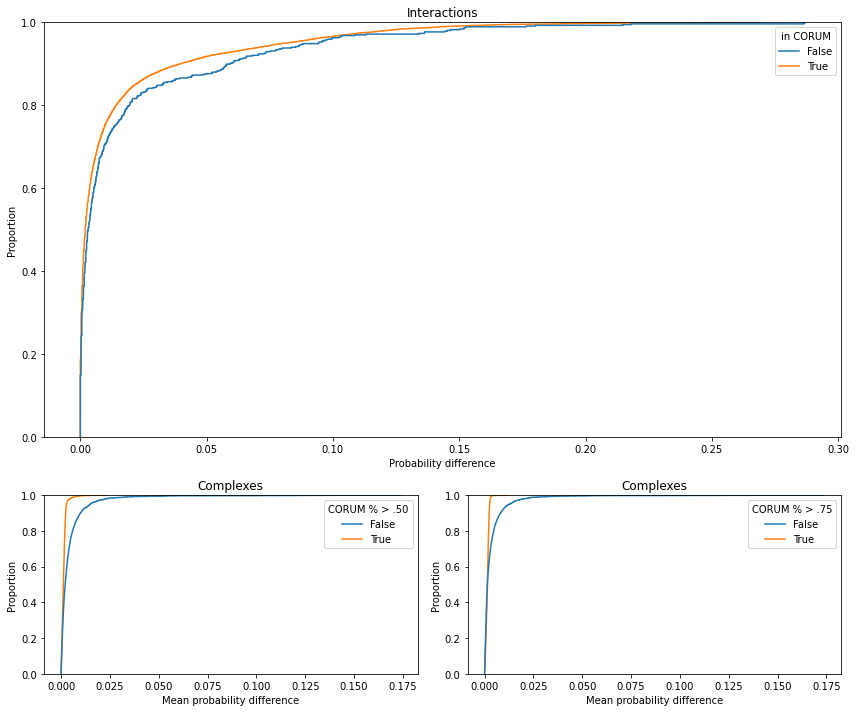

In [ ]:
plt.figure(figsize=(12, 10))
#plt.title('Interactions and complexes shared in common by cell-line-specific predictors overlap with CORUM.')
plotA = plt.subplot2grid((3, 2), (0, 0), rowspan=2, colspan=2)
plotA.set_title('Interactions')
sns.ecdfplot(data=probabilityDifference_rankedList_pairs.rename(columns={'difference': 'Probability difference'}),
             x='Probability difference', hue='in CORUM', stat='proportion')

plotB, plotC = plt.subplot2grid((3, 2), (2, 0)), plt.subplot2grid((3, 2), (2, 1))
evalMeasures = ['CORUM % > .50', 'CORUM % > .75']
for evalMeasure, plot in zip(evalMeasures, [plotB, plotC]):
  plot.set_title('Complexes')
  sns.ecdfplot(
      data=probabilityDifference_rankedList.rename(columns={'meanDifference': 'Mean probability difference'}),
      x='Mean probability difference',
      hue=evalMeasure,
      stat='proportion',
      ax=plot)

plt.tight_layout()

In [ ]:
checkpointVars = \
  ['elcfsPredictions_pairs', 'probabilityDifference_rankedList_pairs',
   'elcfsPredictions_complexes', 'scoredComplexes', 'probabilityDifference_rankedList',
   'corumComplexes']

pickle.dump(
    {key: globals()[key] for key in checkpointVars},
    open('./checkpointVars_GoogleColab_complexesAnalyses_01222023.pkl', 'wb')
)